In [1]:
#Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

In [2]:
# Reading the file
df=pd.read_csv("ratings_Electronics .csv")

In [3]:
# Assigning headings to each column
df.columns=['userID','ProductID','Rating','Timestamp']

In [4]:
df.tail()

,userID,ProductID,Rating,Timestamp
1048570,A1H16CBCNEL4G3,B000IF51UQ,5,1356739200
1048571,A1C2OANTC49AQI,B000IF51UQ,5,1382486400
1048572,A2JL0387FDDFS,B000IF51UQ,5,1340409600
1048573,A2KIYE5RF0OEMY,B000IF51UQ,4,1391212800
1048574,A1G9Q5UJ5Y7DES,B000IF51UQ,2,1390780800


In [5]:
df.shape

(1048575, 4)

## No.rows - 1048575
## No.columns - 4

In [6]:
df.dtypes

userID       object
ProductID    object
Rating        int64
Timestamp     int64
dtype: object

### User ID and Project are categorical feature whereas Rating and Timestamp are numerical features.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
userID       1048575 non-null object
ProductID    1048575 non-null object
Rating       1048575 non-null int64
Timestamp    1048575 non-null int64
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


### Seems like there are no missing values

In [8]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userID,1048575,786329,A5JLAU2ARJ0BO,412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductID,1048575,61893,B0002L5R78,9487,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,1.04858e+06,NaN,NaN,NaN,3.97338,1.39933,1,3,5,5,5
Timestamp,1.04858e+06,NaN,NaN,NaN,1.24882e+09,1.09161e+08,9.1273e+08,1.16908e+09,1.25004e+09,1.35579e+09,1.40607e+09


### Top rating is 5 and it is observed that 5 is maximum in the datasets since 50 percent,75 percent and max are 5.

In [9]:
### Checking missing values
df.isnull().sum()

userID       0
ProductID    0
Rating       0
Timestamp    0
dtype: int64

### This also confirms that there are no missing values in the datsaset.

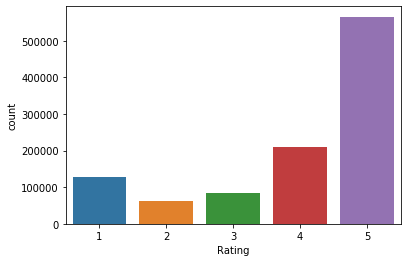

In [10]:
sns.countplot(df.Rating)

### This again confirms that maximum rating is 5 and 4 and 2 appears the least.

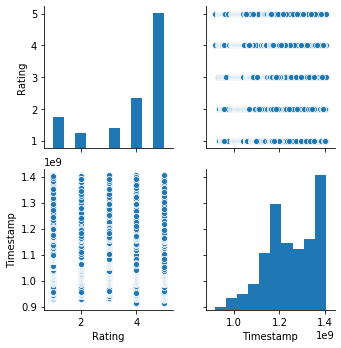

In [11]:
sns.pairplot(df)

In [12]:
ratings=pd.DataFrame(df.groupby('ProductID')['Rating'].mean())
ratings['Number_Of_Ratings']=pd.DataFrame(df.groupby('ProductID')['Rating'].count())
ratings.head()

,Rating,Number_Of_Ratings
ProductID,,
059400232X,5.0,3
089933623X,2.5,2
094339676X,5.0,1
1034385789,4.4,5
1039869017,5.0,2


### there are few products with very few number of ratings.

Text(0.5, 1.0, 'Distribution of Ratings')

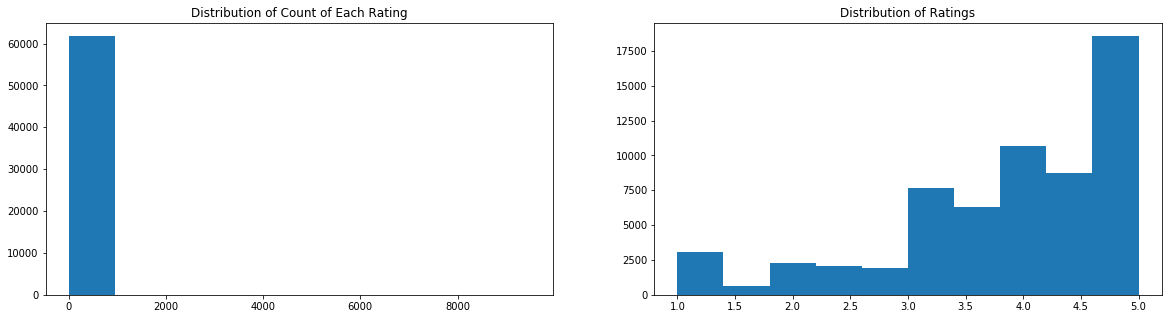

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(ratings.Number_Of_Ratings)
plt.title('Distribution of Count of Each Rating')

plt.subplot(1,2,2)
plt.hist(ratings.Rating)
plt.title('Distribution of Ratings')

In [14]:
ratings.describe()

,Rating,Number_Of_Ratings
count,61893.000000,61893.000000
mean,3.853758,16.941738
std,1.076955,89.707538
min,1.000000,1.000000
25%,3.250000,1.000000
50%,4.000000,3.000000
75%,4.750000,9.000000
max,5.000000,9487.000000


In [15]:
#There seems to be a few outliers for Number of Ratings. The highest value is insanely high.

Q1=np.percentile(ratings['Number_Of_Ratings'],25)
Q3=np.percentile(ratings['Number_Of_Ratings'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
Outliers=ratings[ratings['Number_Of_Ratings']>UL]['Number_Of_Ratings']
Outliers.shape

(8083,)

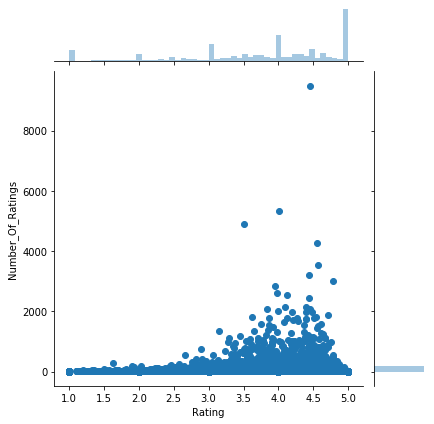

In [16]:
sns.jointplot(ratings.Rating,ratings.Number_Of_Ratings)

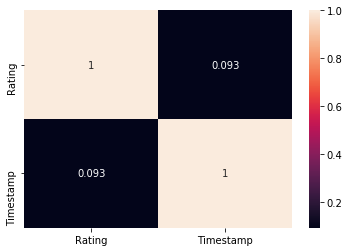

In [17]:
corr=df.corr()
sns.heatmap(corr,annot=True)

### No great co-relation is noticed. But it is noticeable that products with lower ratings have lesser number of users rating it.

In [18]:
counts=df.userID.value_counts()
counts.sort_values(ascending=True).head()

A20F2MVG78MUWM    1
AJXPVOKHKI1GI     1
A25JH6CO4DVINS    1
A4XZ7EENI874W     1
A1RONF7ZIQERJN    1
Name: userID, dtype: int64

### Seems like there a lot of users who have provided very few ratings. Considering the entries from these users may not contribute much to the recommendation system we want to build, we may drop all users who have rated less than 25 times

In [19]:
df=df[df['userID'].isin(counts[counts >= 25].index)]
df.shape

(9549, 4)

In [20]:
df.head()

,userID,ProductID,Rating,Timestamp
177,A17HMM1M7T9PJ1,970407998,4,1281744000
2081,A2ZR3YTMEEIIZ4,1400532655,5,1300233600
2161,A5JLAU2ARJ0BO,1400532655,1,1291334400
3049,ALUNVOQRXOZIA,1400599997,1,1271548800
3629,ABVYGB2TKBO8F,1685560148,5,1351468800


Text(0.5, 1.0, 'Distribution of Ratings')

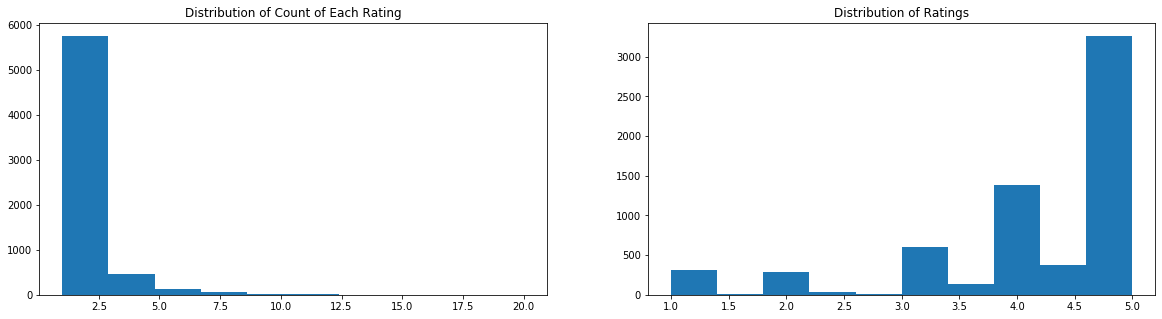

In [21]:
ratings=pd.DataFrame(df.groupby('ProductID')['Rating'].mean())
ratings['Number_Of_Ratings']=pd.DataFrame(df.groupby('ProductID')['Rating'].count())

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(ratings.Number_Of_Ratings)
plt.title('Distribution of Count of Each Rating')

plt.subplot(1,2,2)
plt.hist(ratings.Rating)
plt.title('Distribution of Ratings')

### This looks a much better distribution than before, with very high proportion of people having rated products as 4 or 5. However most of the products seem to have been rated only once or twice.

In [22]:
ratings.Number_Of_Ratings.value_counts(normalize=True)

1     0.758766
2     0.138694
3     0.050335
4     0.020259
5     0.011999
6     0.006701
7     0.005298
8     0.002805
9     0.001714
11    0.000935
10    0.000623
12    0.000468
18    0.000312
14    0.000312
16    0.000156
15    0.000156
20    0.000156
13    0.000156
17    0.000156
Name: Number_Of_Ratings, dtype: float64

In [23]:
counts=df.userID.value_counts()
counts.sort_values(ascending=True).head()

A2JFOHC9W629IE    25
ACH055GTTIGC9     25
A3KTWUXXB8KKC7    25
AAQ9NJ480N9W5     25
AEJAGHLC675A7     25
Name: userID, dtype: int64

In [24]:
#converting the dataframe to format supported by surprise package
from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(df[['userID', 'ProductID', 'Rating']], reader)

In [25]:

trainset,testset = train_test_split(data, test_size=0.30)

In [26]:
from surprise import SVD, accuracy
algo = SVD()
algo.fit(trainset)

predictions = algo.test(testset)

In [27]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 1.0486


1.0485514346159892

In [28]:
results=pd.DataFrame({'SVD':[1.741]}, index=['RMSE'])
results

,SVD
RMSE,1.741


In [29]:
from collections import defaultdict
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [30]:
#Top 5 recommendations per user is below (alongwith the ratings of those products)

top_n = get_top_n(predictions, n=5)
top_n

defaultdict(list,
            {'A5JLAU2ARJ0BO': [('B000071NY3', 4.671233123394961),
              ('B00004SB92', 4.650175898415295),
              ('B000ETVKHE', 4.636652466715275),
              ('B00005QFZG', 4.576697802590131),
              ('B0002IWC9C', 4.451957821098692)],
             'A2BMZRO0H7TFCS': [('B00004Z6PI', 4.108598442647791),
              ('B00006HZ0L', 4.00043353343866),
              ('B00066EK2W', 3.98554197587896),
              ('B0007NWL70', 3.840737365869812),
              ('B0000AE82C', 3.8292870194476794)],
             'A1435P5AMCPB3X': [('B00008Y1BX', 4.630614819999094),
              ('B000BT2PZS', 4.574822517294676),
              ('B0000659UN', 4.511736046005048),
              ('B000204SWE', 4.411064667496457),
              ('B000F9LS0W', 4.360546922617034)],
             'A3977M5S0GIG5H': [('B0000BVYTV', 4.723160557442107),
              ('B00005T39Y', 4.661201453273836),
              ('B0000U19F0', 4.633181230184721),
              ('B0000C0XS0'

In [31]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A5JLAU2ARJ0BO ['B000071NY3', 'B00004SB92', 'B000ETVKHE', 'B00005QFZG', 'B0002IWC9C']
A2BMZRO0H7TFCS ['B00004Z6PI', 'B00006HZ0L', 'B00066EK2W', 'B0007NWL70', 'B0000AE82C']
A1435P5AMCPB3X ['B00008Y1BX', 'B000BT2PZS', 'B0000659UN', 'B000204SWE', 'B000F9LS0W']
A3977M5S0GIG5H ['B0000BVYTV', 'B00005T39Y', 'B0000U19F0', 'B0000C0XS0', 'B000BI3VSO']
A1TBH7Z4RK7PRK ['B00004SB92', 'B000068U26', 'B0001W1I5S', 'B0000AB4NQ', 'B00007079A']
A3OXHLG6DIBRW8 ['B00004ZCJE', 'B000F5FKHI', 'B000093UDQ', 'B00004VV4J', 'B000GG5LUW']
A71RAEJ3JK2RN ['B000BYGGBM', 'B00006HMPH', 'B0001YFXCA', 'B00076TK4O', 'B0009OY8VE']
A1QVFHPY8418HC ['B00009EHJV', 'B0007LBO7A', 'B000EOMXM0', 'B0002D0E6U', 'B0002YK9SW']
ASCM3206SVTO0 ['B00006JLOT', 'B0000C8817', 'B00005UKBD', 'B00005T3BG', 'B000B68I2K']
A3NOBH42C7UI5M ['B00006LV79', 'B000EWHH7I', 'B000CSEL4Q', 'B0000YTKT8', 'B0003QER7S']
ATDE9JYCPI0L1 ['B0007YFQH6', 'B000HKIPVE', 'B000I1YTGC', 'B00000J03B', 'B000053VYB']
A1VQHH85U7PX0 ['B000AZ57M6', 'B000EW8074', 'B000BUK7KW', '

In [32]:
### Grid search
param_grid = {
    "n_epochs": [10,15,20,25],
    "lr_all": [0.02,0.03,0.04,0.05],
    "reg_all": [0.03,0.04,0.05,0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.0626501360734897
{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0.05}


In [33]:
algo = SVD(n_epochs= 25, lr_all=0.04, reg_all=0.03)
algo.fit(trainset)

predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 1.0521


1.052133085219644

In [34]:
results['SVD_tuned']=[1.0820]
results

,SVD,SVD_tuned
RMSE,1.741,1.082


In [35]:
#Top 5 recommendations per user is below

top_n = get_top_n(predictions, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A5JLAU2ARJ0BO ['B00005LEN4', '1400532655', 'B00006B7HB', 'B0001H4BMU', 'B0001BRITE']
A2BMZRO0H7TFCS ['B00066EK2W', 'B00004Z6PI', 'B00006HZ0L', 'B0007NWL70', 'B0000AE82C']
A1435P5AMCPB3X ['B000204SWE', 'B000A7B9XK', 'B0000659UN', 'B00008Y1BX', 'B000BT2PZS']
A3977M5S0GIG5H ['B0000BVYTV', 'B0000C0XS0', 'B00005T39Y', 'B0000U19F0', 'B000BI3VSO']
A1TBH7Z4RK7PRK ['B00004SB92', 'B000068U26', 'B0001W1I5S', 'B0000AB4NQ', 'B00007079A']
A3OXHLG6DIBRW8 ['B000093UDQ', 'B00012FVYC', 'B00004ZCJE', 'B00004VV4J', 'B000GG5LUW']
A71RAEJ3JK2RN ['B00065JM94', 'B000BYGGBM', 'B00006HMPH', 'B0001YFXCA', 'B00076TK4O']
A1QVFHPY8418HC ['B00009EHJV', 'B0007LBO7A', 'B000EOMXM0', 'B0009VT9OS', 'B0002D0E6U']
ASCM3206SVTO0 ['B0000C8817', 'B000B68I2K', 'B00008IHU2', 'B00006RGRJ', 'B00005S8KM']
A3NOBH42C7UI5M ['B00006LV79', 'B000CSEL4Q', 'B0000YTKT8', 'B0003QER7S', 'B0002PS51Y']
ATDE9JYCPI0L1 ['B000HKIPVE', 'B0007YFQH6', 'B000BI2180', 'B000I1YTGC', 'B00000J03B']
A1VQHH85U7PX0 ['B0000A1G05', 'B000EW8074', 'B000BKJZ9Q', '

In [36]:

# Collaborative filtering

In [37]:
from surprise import KNNWithMeans
algo = KNNWithMeans(k=25, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)
test_pred = algo.test(testset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [38]:

# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.1415


1.14150594338951

In [39]:

results['User-User_CF']=[1.17839]
results

,SVD,SVD_tuned,User-User_CF
RMSE,1.741,1.082,1.17839


In [40]:
# Top 5 recommendations
top_n = get_top_n(test_pred, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A5JLAU2ARJ0BO ['B0001F22PA', 'B0000CH58M', 'B00006RSJ1', 'B000071NY3', 'B00008LDHZ']
A2BMZRO0H7TFCS ['B0000AE82C', 'B0007WKB0U', 'B000023VW5', 'B00004Z0BM', 'B00015Y0FK']
A1435P5AMCPB3X ['B0000659UN', 'B000204SWE', 'B000BT2PZS', 'B00004TBBA', 'B000A7B9XK']
A3977M5S0GIG5H ['B00005T39Y', 'B0000C0XS0', 'B0000BVYTV', 'B0000U19F0', 'B000BI3VSO']
A1TBH7Z4RK7PRK ['B00004SB92', 'B000068U26', 'B0001W1I5S', 'B0000AB4NQ', 'B00007079A']
A3OXHLG6DIBRW8 ['B00004ZCJE', 'B00012FVYC', 'B000093UDQ', 'B000F5FKHI', 'B00004VV4J']
A71RAEJ3JK2RN ['B000BYGGBM', 'B00006HMPH', 'B0001YFXCA', 'B00076TK4O', 'B0009OY8VE']
A1QVFHPY8418HC ['B0009VT9OS', 'B0007LBO7A', 'B00009EHJV', 'B000EOMXM0', 'B0002D0E6U']
ASCM3206SVTO0 ['B000B68I2K', 'B00008IHU2', 'B0000C8817', 'B00005QCO1', 'B00005UKBD']
A3NOBH42C7UI5M ['B000EWHH7I', 'B0000YTKT8', 'B0003QER7S', 'B0002PS51Y', 'B0002PS4EW']
ATDE9JYCPI0L1 ['B000I1YTGC', 'B00000J03B', 'B000053VYB', 'B000FUOO3E', 'B0009NF48G']
A1VQHH85U7PX0 ['B000AZ57M6', 'B0000A1G05', 'B000BKJZ9Q', '

In [41]:
# Let's tune the model and see if we can get better results

sim_options = {
    "name": ["msd", "cosine", "pearson_baseline"],
        "min_support": [25,50,75],
    "user_based": [True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix.

In [42]:
algo = KNNWithMeans(k=25, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)
test_pred = algo.test(testset)
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
User-based Model : Test Set
RMSE: 1.1433


1.1433411075299633

In [43]:
results['Use-User_CF_Tuned']=[1.17797]
results

,SVD,SVD_tuned,User-User_CF,Use-User_CF_Tuned
RMSE,1.741,1.082,1.17839,1.17797


In [44]:
### top 5 recommendations
top_n = get_top_n(test_pred, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A5JLAU2ARJ0BO ['B0001F22PA', 'B0000CH58M', 'B000071NY3', 'B00008LDHZ', '1400532655']
A2BMZRO0H7TFCS ['B0000AE82C', 'B0007WKB0U', 'B000023VW5', 'B00004Z0BM', 'B00015Y0FK']
A1435P5AMCPB3X ['B0000659UN', 'B000204SWE', 'B000BT2PZS', 'B00004TBBA', 'B000A7B9XK']
A3977M5S0GIG5H ['B00005T39Y', 'B0000C0XS0', 'B0000BVYTV', 'B0000U19F0', 'B000BI3VSO']
A1TBH7Z4RK7PRK ['B00004SB92', 'B000068U26', 'B0001W1I5S', 'B0000AB4NQ', 'B00007079A']
A3OXHLG6DIBRW8 ['B00004ZCJE', 'B00012FVYC', 'B000093UDQ', 'B000F5FKHI', 'B00004VV4J']
A71RAEJ3JK2RN ['B000BYGGBM', 'B00006HMPH', 'B0001YFXCA', 'B00076TK4O', 'B0009OY8VE']
A1QVFHPY8418HC ['B0009VT9OS', 'B000BQ57BU', 'B0007LBO7A', 'B00009EHJV', 'B000EOMXM0']
ASCM3206SVTO0 ['B000B68I2K', 'B00008IHU2', 'B0000C8817', 'B00005QCO1', 'B00005UKBD']
A3NOBH42C7UI5M ['B000EWHH7I', 'B0000YTKT8', 'B0003QER7S', 'B0002PS51Y', 'B0002PS4EW']
ATDE9JYCPI0L1 ['B000I1YTGC', 'B00000J03B', 'B000053VYB', 'B000FUOO3E', 'B0009NF48G']
A1VQHH85U7PX0 ['B0000A1G05', 'B000AZ57M6', 'B000BKJZ9Q', '

In [45]:
#Try Matrix based and svd for recorrelations based on correlation

#Generate matrix table

ratings_matrix = df.pivot(index='userID', columns='ProductID', values='Rating').fillna(0)
userID = ratings_matrix.index
ProductID = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(226, 6417)


ProductID,1400532655,1400599997,1685560148,787988002X,9043413585,970407998,9981719005,998376234X,9985734459,B000000O2F,...,B000ID6DTG,B000ID7QNI,B000IDCDZY,B000IDWDKO,B000IE1KZC,B000IE5XIC,B000IE8Z4Q,B000IEVASY,B000IF4788,B000IF51UQ
userID,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11EYMH9UV9XG7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11KZ906QD08C5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
### since NaNs cannot be handled by training algos, replacing these by 0, which indicates absence of ratings



In [47]:
ratings.sort_values('Number_Of_Ratings', ascending=False).head(20)

,Rating,Number_Of_Ratings
ProductID,,
B00007KDVI,3.500000,20
B00007E7JU,4.555556,18
B00004ZCJE,4.444444,18
B00004SB92,4.470588,17
B00005LEN4,4.687500,16
B0007QKMQY,4.733333,15
B000AZ57M6,4.642857,14
B00009XVCZ,4.714286,14
B00008OE6I,4.769231,13


In [48]:
#Lets choose product 1400532655 and store its tarings in a series

ProdID_ratings=ratings_matrix['B00007E7JU']



In [49]:
#We can find the correlation between this and matrix with all product ratings
Similar_to_prod_rating=ratings_matrix.corrwith(ProdID_ratings)


In [50]:

# For Product with ID=B00007E7JU, the 10 products that will be recommended are given above


In [51]:

cor_with_prod=pd.DataFrame(Similar_to_prod_rating,columns=['Corelation']).sort_values('Corelation', ascending=False)
cor_with_prod.head(11)

,Corelation
ProductID,
B00007E7JU,1.000000
B0009JO2YC,0.349981
B00005T3N0,0.347821
B000DZDTKU,0.336350
B000HATNI8,0.312245
B0000A0AEM,0.311992
B0000A1G05,0.305735
B00004YZQ8,0.295726
B00009U0XI,0.295726


In [52]:
df.columns


Index(['userID', 'ProductID', 'Rating', 'Timestamp'], dtype='object')

In [53]:

# Popularity based reccomendation
df.groupby('ProductID')['Rating'].mean().head()


ProductID
1400532655    3.0
1400599997    1.0
1685560148    5.0
787988002X    5.0
9043413585    3.0
Name: Rating, dtype: float64

In [54]:

df.groupby('ProductID')['Rating'].mean().sort_values(ascending=False).head()



ProductID
B00016USAA    5.0
B000067VKY    5.0
B0002J2TLC    5.0
B0002J2P1Q    5.0
B0002J2O26    5.0
Name: Rating, dtype: float64

In [55]:
df.groupby('ProductID')['Rating'].count().sort_values(ascending=False).head()

ProductID
B00007KDVI    20
B00004ZCJE    18
B00007E7JU    18
B00004SB92    17
B00005LEN4    16
Name: Rating, dtype: int64

In [56]:

ratings_mean_count = pd.DataFrame(df.groupby('ProductID')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('ProductID')['Rating'].count())
ratings_mean_count.head()


,Rating,rating_counts
ProductID,,
1400532655,3.0,2
1400599997,1.0,1
1685560148,5.0,1
787988002X,5.0,1
9043413585,3.0,1


In [57]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size = 0.20, random_state=0)
train_data.head()

,userID,ProductID,Rating,Timestamp
351260,A6FIAB28IS79,B0000TQ154,3,1194393600
339751,A231WM2Z2JL0U3,B0000CEOYI,5,1068940800
109052,A231WM2Z2JL0U3,B00005NDUP,5,1025308800
64062,A3MEIR72XKQY88,B00004YV8E,4,976320000
666847,A3W4D8XOGLWUN5,B0009JB7P4,5,1161388800


In [58]:
#Count of user_id for each unique song as recommendation score 
train_data_grouped = train_data.groupby('ProductID').agg({'userID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userID': 'score'},inplace=True)
train_data_grouped.head()

,ProductID,score
0,1400532655,2
1,1400599997,1
2,1685560148,1
3,787988002X,1
4,9043413585,1


In [59]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductID,score,Rank
1662,B00007E7JU,17,1.0
1724,B00007KDVI,17,2.0
772,B00005LEN4,14,3.0
262,B00004SB92,13,4.0
549,B00004ZCJE,13,5.0


In [60]:
# Recommendations for any random user using the model

# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

test_data.head()

,userID,ProductID,Rating,Timestamp
64164,A2BGZ52M908MJY,B00004YZLV,4,987465600
443086,A31N0XY2UTB25C,B00029U1DK,5,1331424000
60584,A8TZ88OM8YOLW,B00004X0ZH,5,1035676800
130474,A14ME4FQBNFYWH,B000062STU,5,1042675200
576841,A2BCDZO1XQLDH,B0006VYGRG,4,1114560000


In [61]:

test_data.index

Int64Index([ 64164, 443086,  60584, 130474, 576841, 578661, 883070, 342931,
            196904,  47460,
            ...
            304579, 159428, 332798, 343764, 338287, 461481, 134884, 633824,
             70369,  64421],
           dtype='int64', length=1910)

In [62]:
find_recom = test_data.index   # This list is user choice.
for i in find_recom:
    
    print(recommend(i))    
    print("\n")

      userID   ProductID  score  Rank
1662   64164  B00007E7JU     17   1.0
1724   64164  B00007KDVI     17   2.0
772    64164  B00005LEN4     14   3.0
262    64164  B00004SB92     13   4.0
549    64164  B00004ZCJE     13   5.0


      userID   ProductID  score  Rank
1662  443086  B00007E7JU     17   1.0
1724  443086  B00007KDVI     17   2.0
772   443086  B00005LEN4     14   3.0
262   443086  B00004SB92     13   4.0
549   443086  B00004ZCJE     13   5.0


      userID   ProductID  score  Rank
1662   60584  B00007E7JU     17   1.0
1724   60584  B00007KDVI     17   2.0
772    60584  B00005LEN4     14   3.0
262    60584  B00004SB92     13   4.0
549    60584  B00004ZCJE     13   5.0


      userID   ProductID  score  Rank
1662  130474  B00007E7JU     17   1.0
1724  130474  B00007KDVI     17   2.0
772   130474  B00005LEN4     14   3.0
262   130474  B00004SB92     13   4.0
549   130474  B00004ZCJE     13   5.0


      userID   ProductID  score  Rank
1662  576841  B00007E7JU     17   1.0
1724

### We can see that the recommendations for each user is the same five products. That is so becasue each use gets recommended with the products which have had the top five average ratings, irrespective of what the users perdonal preferences are.

### However the other models built prior to the popularity based model, try to identify the tastes of the user and find the products similar to it and recommend the products with highest similarity.

### Hence if we want to build a recommemdation system which is able to recommend to the user, the products he may like to buy, popularity based recommendation system may not be the right idea.

### Amongst the matrix based, SVD and Collaborative filtering, the model with best results must be chosen.

In [63]:
results

,SVD,SVD_tuned,User-User_CF,Use-User_CF_Tuned
RMSE,1.741,1.082,1.17839,1.17797
